# Reinforcement Learning Project

Mr.Pasin Jiratthiticheep<br/>
Student ID. : 1900555

## Introduction

In this project, I expect to learn and try to use RL library in python to solve the Breakout Atari game from Gym's environment. I found this blog "<a href="https://towardsdatascience.com/atari-reinforcement-learning-in-depth-part-1-ddqn-ceaa762a546f">Atari - Solving Games with AI</a>" and link to this Github "<a href="https://github.com/gsurma/atari">AI research environment for the Atari 2600 games</a>" that it is very useful for learning, even it didn't use Keras-rl library for implementation. I choose to use Keras-rl library to implement my agent because, I'm quite familiar with Keras library for implementing Deep learning model. But the <a href="https://keras-rl.readthedocs.io/en/latest/"> Keras-rl library document </a> isn't complete and contain lacking useful information. So, I have to learn from the source code of the library instead that take me longer time to understand(<a href="https://github.com/keras-rl/keras-rl">Keras-rl library Github</a>).

** Number of running cell and output of this notebook maybe missing or disorder that because during training agent my latop restart couple of times so I have to start execute at some middle cell **

In [1]:
from __future__ import division

from PIL import Image
import numpy as np
import gym
import pandas as pd
import matplotlib.pyplot as plt
import json
import math

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D
from keras.optimizers import Adam, RMSprop
import keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

Using TensorFlow backend.


In [2]:
# Size of images that is input from environment
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4
FRAME_SIZE = 84

# Environment Name
env_name = 'BreakoutDeterministic-v4'

# Get the environment and extract the number of actions.
env = gym.make(env_name)
nb_actions = env.action_space.n

# Input shape for deep model
input_shape = (WINDOW_LENGTH, FRAME_SIZE, FRAME_SIZE)

First, We defined a <b>processor</b> for preprocessing observation information that we get from the environment. A processor acts as a coupling mechanism between an Agent and its Env. This can be necessary when our agent has different requirements with respect to the form of the observations, actions, and rewards of the environment. In this case, <b>we resize and convert observation gameplay image into (84*84) pixel and grayscale image</b>. We didn't need high-resolution image because it wasn't every pixel in the images will have useful information and gray scale used to reduce complexity and size of the input (by feeding color image, we need 3 layers for each frame that represent RGB) to the deep model.

In [3]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # Stored memory type
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        # Clip reward into range -1 to 1
        return np.clip(reward, -1., 1.)

Next, I define 2 functions for the convenience of future work. The run_agent was used to train and test the specific agent. And the plot function was used to plot the training result from the saved log file to show the performance of the agent.

In [4]:
def run_agent(env_name, env, agent, Nb_steps=875000, Interval=125000, mode='train', weights=None, Visualize=False):
    if mode == 'train':
        # Define file names for saving weight and log
        weights_filename = 'agent_{}_weights.h5f'.format(env_name)
        checkpoint_weights_filename = 'dqn_' + env_name + '_weights_{step}.h5f'
        log_filename = 'agent_{}_log.json'.format(env_name)
        
        # Define log callback and weight saving checkpoint during the training process
        callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=Interval)]
        callbacks += [FileLogger(log_filename, interval=50)]
        
        # Training the agent
        agent.fit(env, callbacks=callbacks, nb_steps=Nb_steps, log_interval=Nb_steps/100, visualize=Visualize)

        # After training is done, we save the final weights one more time.
        agent.save_weights(weights_filename, overwrite=True)

        # Finally, evaluate our algorithm for 3 episodes.
        agent.test(env, nb_episodes=3, visualize=Visualize)
        
    elif mode == 'test':
        # Load trained weight into the agent
        if weights:
            weights_filename = weights
        agent.load_weights(weights_filename)
        
        # Evaluate for 3 episodes
        agent.test(env, nb_episodes=3, visualize=True)

In [5]:
def plot(input_path, y_label):
        # Load training log from log file
        with open(input_path, "r") as input_file:
            reader = json.load(input_file)
        x = reader['episode']
        y = reader[y_label]
        
        # Plot into the graph
        plt.subplots()
        plt.plot(x, y, label=y_label)
        
        # Draw trend line
        y_trend = [0 if math.isnan(value) else value for value in y]
        if len(x) > 1:
            trend_x = x
            z = np.polyfit(trend_x, y_trend, 1)
            p = np.poly1d(z)
            plt.plot(trend_x, p(trend_x), linestyle="-.",  label="trend")
        
        # Printing average score of last 20 episodes
        if y_label == "episode_reward":
            print("Average score from last 20 episodes: ",np.average(y_trend[-20:]))
        
        # Graph setting
        plt.xlabel("update")
        plt.ylabel(y_label)
        if y_label == 'loss':
            plt.ylim([0,0.01])
        plt.legend(loc="upper left")
        plt.show()

I used the <b>convolutional neural network designed by Deep Mind</b> for training my agent. You can see the structure of the model below.

In [6]:
# Design model from Deepmind
def create_model():
    model = Sequential()
    model.add(Convolution2D(32,
                    8,
                    strides=(4, 4),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape,
                    data_format="channels_first"))
    model.add(Convolution2D(64,
                    4,
                    strides=(2, 2),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape,
                    data_format="channels_first"))
    model.add(Convolution2D(64,
                    3,
                    strides=(1, 1),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape,
                    data_format="channels_first"))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dense(nb_actions))
    model.compile(loss="mean_squared_error",
                    optimizer=RMSprop(lr=0.00025,
                    rho=0.95,
                    epsilon=0.01),
                    metrics=["accuracy"])
#     print(model.summary())
    
    return model

These hyperparameters based on my reference sources (Unfortunately, I couldn't find any document that can explain the purpose of some parameters, so this is meaning of each parameter based on my understanding)

    * GAMMA : Discount factor
    * MEMORY_SIZE : Maximum size of memory to keep the experiences
    * BATCH_SIZE : The number of experiences that be sampled from the memory
    * TRAINING_FREQUENCY : Perform training every n total steps taken by the agent
    * TARGET_NETWORK_UPDATE_FREQUENCY : How many running step before update target network
    * REPLAY_START_SIZE : Running step without training network

    * EXPLORATION_MAX : Maximum value of expolration rate
    * EXPLORATION_MIN : Minimum value of expolration rate
    * EXPLORATION_TEST : expolration rate for testing
    * EXPLORATION_STEPS : Used to calculate linear annealed function: f(x) = ax + b
    
After the couple of experiments of training the agent, I make sure that these value of hyperparameters and the other parameters (nb_step, and interval) are suitable for my resource and time.

In [7]:
GAMMA = 0.99
MEMORY_SIZE = 900000
BATCH_SIZE = 32
TRAINING_FREQUENCY = 4
TARGET_NETWORK_UPDATE_FREQUENCY = 40000
REPLAY_START_SIZE = 50000

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.1
EXPLORATION_TEST = 0.02
EXPLORATION_STEPS = 850000

## DQN Agent

The first model of agent, I used Deep Q-learing network with fixed Q-target. The concept of DQN is by using a separate network with a fixed parameter for estimating the TD target (for non-fixed Q-target, every step of training, our Q values shift but also the target value shifts because both values based on weight of model. So, we’re getting closer to our target but the target is also moving). Then, at every TARGET_NETWORK_UPDATE_FREQUENCY step, we copy the parameters from our DQN network to update the target network.

In [7]:
memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

# Select a policy. We use eps-greedy action selection, which means that a random action is selected with probability eps.
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=EXPLORATION_MAX, value_min=EXPLORATION_MIN,
                              value_test=EXPLORATION_TEST, nb_steps=EXPLORATION_STEPS)

In [8]:
# define model
model = create_model()

# DQN agent
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=REPLAY_START_SIZE, gamma=GAMMA,
               target_model_update=TARGET_NETWORK_UPDATE_FREQUENCY, enable_double_dqn=False,
               train_interval=TRAINING_FREQUENCY, batch_size=32, delta_clip=1.)
dqn.compile(Adam(lr=.00025), metrics=['mae'])

run_agent(env_name+'_DQN', env, dqn, Nb_steps=2500000, Interval=250000, mode='train')

Training for 2500000 steps ...
Interval 1.0 (0 steps performed)
25000/25000 [==============================] - 84s 3ms/step - reward: 0.0066
137 episodes - episode_reward: 1.197 [0.000, 6.000] - ale.lives: 2.859

Interval 2.0 (25000 steps performed)
25000/25000 [==============================] - 83s 3ms/step - reward: 0.0063
139 episodes - episode_reward: 1.129 [0.000, 5.000] - ale.lives: 2.939

Interval 3.0 (50000 steps performed)
25000/25000 [==============================] - 305s 12ms/step - reward: 0.0066
139 episodes - episode_reward: 1.194 [0.000, 5.000] - loss: 0.001 - mean_absolute_error: 0.110 - mean_q: 0.150 - mean_eps: 0.934 - ale.lives: 2.988

Interval 4.0 (75000 steps performed)
25000/25000 [==============================] - 309s 12ms/step - reward: 0.0058
143 episodes - episode_reward: 1.021 [0.000, 5.000] - loss: 0.001 - mean_absolute_error: 0.114 - mean_q: 0.154 - mean_eps: 0.907 - ale.lives: 2.919

Interval 5.0 (100000 steps performed)
25000/25000 [====================

Interval 63.0 (1550000 steps performed)
25000/25000 [==============================] - 441s 18ms/step - reward: 0.0220
24 episodes - episode_reward: 23.333 [10.000, 37.000] - loss: 0.001 - mean_absolute_error: 0.805 - mean_q: 1.087 - mean_eps: 0.100 - ale.lives: 3.015

Interval 64.0 (1575000 steps performed)
25000/25000 [==============================] - 450s 18ms/step - reward: 0.0209
27 episodes - episode_reward: 19.667 [8.000, 34.000] - loss: 0.001 - mean_absolute_error: 0.813 - mean_q: 1.097 - mean_eps: 0.100 - ale.lives: 2.956

Interval 65.0 (1600000 steps performed)
25000/25000 [==============================] - 474s 19ms/step - reward: 0.0217
29 episodes - episode_reward: 18.448 [6.000, 31.000] - loss: 0.001 - mean_absolute_error: 0.830 - mean_q: 1.116 - mean_eps: 0.100 - ale.lives: 2.807

Interval 66.0 (1625000 steps performed)
25000/25000 [==============================] - 415s 17ms/step - reward: 0.0240
28 episodes - episode_reward: 21.429 [11.000, 39.000] - loss: 0.001 - mea

After training with 2.5M steps for 11.24 hours, this is the performance of the DQN agent:
* Average human score = 31 scores
* <b>DQN agent testing score = 47 scores (151.61%)</b>

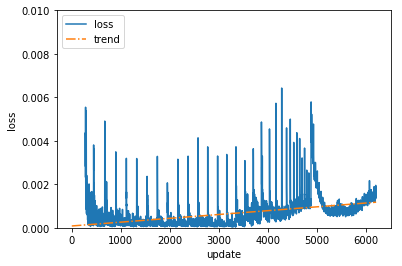

Average score from last 20 episodes:  37.3


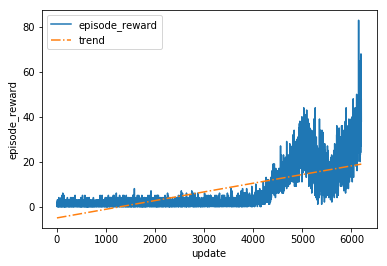

In [4]:
plot("agent_BreakoutDeterministic-v4_DQN_log.json", "loss")
plot("agent_BreakoutDeterministic-v4_DQN_log.json", "episode_reward")

In [10]:
# Clear tensorflow backend session and delete m variable
K.clear_session()
del model

## Double DQN Agent

The next model that I tried is the Double Deep Q-learning target. This method handles the problem of the overestimation of Q-values. By calculating the TD target, we face a simple problem: how are we sure that the best action for the next state is the action with the highest Q-value?
<br/><br/>
The solution is: when we compute the Q target, we use two networks to decouple the action selection from the target Q value generation.:

* use our DQN network to select what is the best action to take for the next state (the action with the highest Q value).
* use our target network to calculate the target Q value of taking that action at the next state.

In [11]:
memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

# Select a policy. We use eps-greedy action selection, which means that a random action is selected with probability eps.
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=EXPLORATION_MAX, value_min=EXPLORATION_MIN,
                              value_test=EXPLORATION_TEST, nb_steps=EXPLORATION_STEPS)

In [ ]:
# define model
model = create_model()

# DDQN agent
double_dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=REPLAY_START_SIZE, gamma=GAMMA,
               target_model_update=TARGET_NETWORK_UPDATE_FREQUENCY, enable_double_dqn=True,
               train_interval=TRAINING_FREQUENCY, batch_size=32, delta_clip=1.)
double_dqn.compile(Adam(lr=.00025), metrics=['mae'])

run_agent(env_name+'_Double_DQN', env, double_dqn, Nb_steps=2500000, Interval=250000, mode='train')

Training for 2500000 steps ...
Interval 1.0 (0 steps performed)
25000/25000 [==============================] - 133s 5ms/step - reward: 0.0053
146 episodes - episode_reward: 0.911 [0.000, 4.000] - ale.lives: 2.936

Interval 2.0 (25000 steps performed)
25000/25000 [==============================] - 91s 4ms/step - reward: 0.0066
138 episodes - episode_reward: 1.188 [0.000, 5.000] - ale.lives: 2.919

Interval 3.0 (50000 steps performed)
25000/25000 [==============================] - 374s 15ms/step - reward: 0.0063
139 episodes - episode_reward: 1.144 [0.000, 5.000] - loss: 0.001 - mean_absolute_error: 0.015 - mean_q: -0.004 - mean_eps: 0.934 - ale.lives: 2.924

Interval 4.0 (75000 steps performed)
25000/25000 [==============================] - 343s 14ms/step - reward: 0.0067
137 episodes - episode_reward: 1.226 [0.000, 6.000] - loss: 0.001 - mean_absolute_error: 0.019 - mean_q: -0.000 - mean_eps: 0.907 - ale.lives: 2.933

Interval 5.0 (100000 steps performed)
25000/25000 [=================

Interval 63.0 (1550000 steps performed)
25000/25000 [==============================] - 403s 16ms/step - reward: 0.0259
24 episodes - episode_reward: 27.083 [16.000, 35.000] - loss: 0.001 - mean_absolute_error: 0.523 - mean_q: 0.713 - mean_eps: 0.100 - ale.lives: 3.165

Interval 64.0 (1575000 steps performed)
25000/25000 [==============================] - 438s 18ms/step - reward: 0.0258
22 episodes - episode_reward: 29.409 [14.000, 40.000] - loss: 0.001 - mean_absolute_error: 0.530 - mean_q: 0.722 - mean_eps: 0.100 - ale.lives: 3.058

Interval 65.0 (1600000 steps performed)
25000/25000 [==============================] - 419s 17ms/step - reward: 0.0255
23 episodes - episode_reward: 27.130 [12.000, 42.000] - loss: 0.001 - mean_absolute_error: 0.545 - mean_q: 0.739 - mean_eps: 0.100 - ale.lives: 3.211

Interval 66.0 (1625000 steps performed)
25000/25000 [==============================] - 404s 16ms/step - reward: 0.0237
20 episodes - episode_reward: 30.400 [13.000, 41.000] - loss: 0.001 - m

After training with 2.5M steps for 11.38 hours, this is the performance of the DQN agent:
* Average human score = 31 scores
* <b>DQN agent testing score = 40 scores (129.03%)</b>

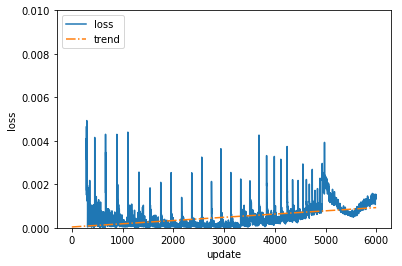

Average score from last 20 episodes:  36.8


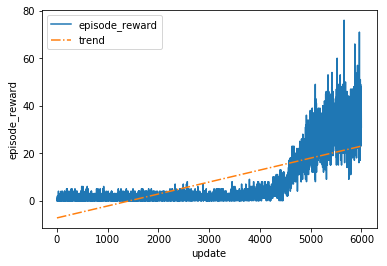

In [5]:
plot("agent_BreakoutDeterministic-v4_Double_DQN_log.json", "loss")
plot("agent_BreakoutDeterministic-v4_Double_DQN_log.json", "episode_reward")

In [ ]:
# Clear tensorflow backend session and delete m variable
K.clear_session()
del model

## Dueling DQN Agent (DDQN)

We can decompose Q(s,a) as the sum of:

* V(s): the value of being at that state
* A(s,a): the advantage of taking that action at that state (how much better is to take this action versus all other possible actions at that state).

With DDQN, we want to separate the estimator of these two elements, using two new streams one that estimates the state value V(s) and another estimates the advantage for each action A(s,a). By decoupling the estimation, intuitively our DDQN can learn which states are (or are not) valuable without having to learn the effect of each action at each state (since it’s also calculating V(s)).

In [7]:
memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

# Select a policy. We use eps-greedy action selection, which means that a random action is selected with probability eps.
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=EXPLORATION_MAX, value_min=EXPLORATION_MIN,
                              value_test=EXPLORATION_TEST, nb_steps=EXPLORATION_STEPS)

In [8]:
# define model
model = create_model()

# Dueling DQN agent
dueldqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=REPLAY_START_SIZE, gamma=GAMMA,
               target_model_update=TARGET_NETWORK_UPDATE_FREQUENCY, enable_double_dqn=False, enable_dueling_network=True,
               train_interval=TRAINING_FREQUENCY, batch_size=32, delta_clip=1.,dueling_type='avg')
dueldqn.compile(Adam(lr=.00025), metrics=['mae'])

run_agent(env_name+'_Dueling_DQN', env, dueldqn, Nb_steps=2500000, Interval=250000, mode='train')

Training for 2500000 steps ...
Interval 1.0 (0 steps performed)
25000/25000 [==============================] - 94s 4ms/step - reward: 0.0066
139 episodes - episode_reward: 1.173 [0.000, 6.000] - ale.lives: 2.930

Interval 2.0 (25000 steps performed)
25000/25000 [==============================] - 88s 4ms/step - reward: 0.0059
145 episodes - episode_reward: 1.021 [0.000, 4.000] - ale.lives: 2.939

Interval 3.0 (50000 steps performed)
25000/25000 [==============================] - 319s 13ms/step - reward: 0.0059
144 episodes - episode_reward: 1.035 [0.000, 6.000] - loss: 0.001 - mean_absolute_error: 0.102 - mean_q: 0.138 - mean_eps: 0.934 - ale.lives: 2.897

Interval 4.0 (75000 steps performed)
25000/25000 [==============================] - 314s 13ms/step - reward: 0.0059
142 episodes - episode_reward: 1.042 [0.000, 5.000] - loss: 0.001 - mean_absolute_error: 0.108 - mean_q: 0.144 - mean_eps: 0.907 - ale.lives: 2.912

Interval 5.0 (100000 steps performed)
25000/25000 [====================

25000/25000 [==============================] - 339s 14ms/step - reward: 0.0262
22 episodes - episode_reward: 29.682 [18.000, 39.000] - loss: 0.001 - mean_absolute_error: 0.761 - mean_q: 1.031 - mean_eps: 0.100 - ale.lives: 3.155

Interval 64.0 (1575000 steps performed)
25000/25000 [==============================] - 336s 13ms/step - reward: 0.0262
21 episodes - episode_reward: 30.238 [16.000, 44.000] - loss: 0.001 - mean_absolute_error: 0.770 - mean_q: 1.043 - mean_eps: 0.100 - ale.lives: 3.143

Interval 65.0 (1600000 steps performed)
25000/25000 [==============================] - 330s 13ms/step - reward: 0.0259
22 episodes - episode_reward: 29.636 [15.000, 46.000] - loss: 0.001 - mean_absolute_error: 0.797 - mean_q: 1.075 - mean_eps: 0.100 - ale.lives: 2.999

Interval 66.0 (1625000 steps performed)
25000/25000 [==============================] - 336s 13ms/step - reward: 0.0264
23 episodes - episode_reward: 28.478 [9.000, 42.000] - loss: 0.001 - mean_absolute_error: 0.804 - mean_q: 1.084

Interval 94.0 (2325000 steps performed)
25000/25000 [==============================] - 342s 14ms/step - reward: 0.0249
20 episodes - episode_reward: 32.650 [19.000, 44.000] - loss: 0.001 - mean_absolute_error: 1.043 - mean_q: 1.407 - mean_eps: 0.100 - ale.lives: 3.317

Interval 95.0 (2350000 steps performed)
25000/25000 [==============================] - 333s 13ms/step - reward: 0.0244
20 episodes - episode_reward: 30.250 [17.000, 50.000] - loss: 0.001 - mean_absolute_error: 1.054 - mean_q: 1.423 - mean_eps: 0.100 - ale.lives: 3.033

Interval 96.0 (2375000 steps performed)
25000/25000 [==============================] - 338s 14ms/step - reward: 0.0248
20 episodes - episode_reward: 31.000 [17.000, 46.000] - loss: 0.001 - mean_absolute_error: 1.059 - mean_q: 1.430 - mean_eps: 0.100 - ale.lives: 3.320

Interval 97.0 (2400000 steps performed)
25000/25000 [==============================] - 324s 13ms/step - reward: 0.0263
19 episodes - episode_reward: 33.947 [23.000, 43.000] - loss: 0.002 - m

After training with 2.5M steps for 9.52 hours, this is the performance of the DQN agent:
* Average human score = 31 scores
* <b>DQN agent testing score = 66 scores (212.9%)</b>

From the testing score, DDQN is the best method for Breakout Atari game. As you can see from the loss function graphs of each mothod, even the loss function was increasing but the reward was also increasing as well. So, if we have more time and resorce for training, we can increase our agent's performance.

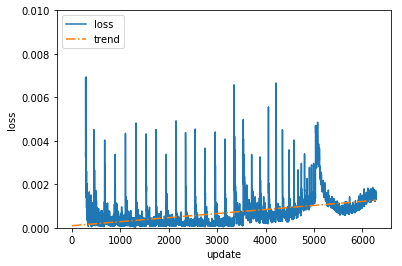

Average score from last 100 episodes:  35.51


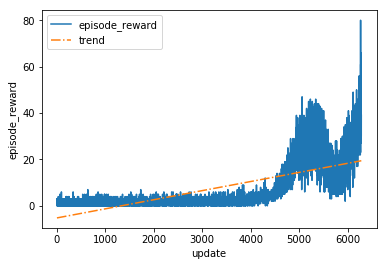

In [9]:
plot("agent_BreakoutDeterministic-v4_Dueling_DQN_log.json", "loss")
plot("agent_BreakoutDeterministic-v4_Dueling_DQN_log.json", "episode_reward")

In [10]:
# Clear tensorflow backend session and delete m variable
K.clear_session()
del model

## Prioritized Experience Replay

It still has some implementation that I found from researching about the reinforcement learning techniques. This Prioritized Experience Replay technique is one of the implementations that I found and hope to implement it with my agent. Unfortunately, the Keras-rl didn't provide this kind of function in their library and implement this in the separate python or modified the original Keras-rl library look like it wasn't fit with the rest of the time.

The idea is that some experiences may be more important than others for our training, but might occur less frequently. Because we sample the batch uniformly (selecting the experiences randomly) these rich experiences that occur rarely have practically no chance to be selected. We want to take in priority experience where there is a big difference between our prediction and the TD target, since it means that we have a lot to learn about it.

## References

<a href="https://towardsdatascience.com/atari-reinforcement-learning-in-depth-part-1-ddqn-ceaa762a546f">Atari - Solving Games with AI 🤖 (Part 1: Reinforcement Learning)</a><br/>
<a href="https://github.com/gsurma/atari">AI research environment for the Atari 2600 games Github</a><br/>
<a href="https://keras-rl.readthedocs.io/en/latest/">Keras-rl library document</a><br/>
<a href="https://github.com/keras-rl/keras-rl">Keras-rl library Github</a><br/>
<a href="https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682">Improvements in Deep Q Learning: Dueling Double DQN, Prioritized Experience Replay, and fixed Q-targets</a>